# Miniproject 5

## Imports and Utilities
**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [ ]:
import sys
import math
import numpy as np
from typing import List
from collections import namedtuple

# Basic data structures.
Pose = namedtuple("Pose", ["x", "y", "theta"])  # x, y coordinate and the rotation of the robot.
Waypoint = namedtuple("Waypoint", ["x", "y"])  # x, y coordinate of the waypoint
Landmark = namedtuple("Landmark", ["x", "y"])   # x, y coordinate of the landmark.
Measurement = namedtuple("Measurement", ["r", "b"])  # r --- distance to the landmark; b --- angle to the landmark, computed by arctan2.
Command = namedtuple("Command", ["delta_p", "delta_theta"])


def eval_gaussian(x, mean=0, var=1):
  """Compute the Gaussian pdf function."""
  return 1.0/math.sqrt(2*math.pi*var)*math.exp(-0.5*(x-mean)**2/var)


class Simulator:
  robot: Pose
  motion_noise_covariance: np.ndarray  # 2x2 covariance matrix of the motion noise.
  sensor_noise_covariance: np.ndarray  # 2x2 covariance matrix of the sensor noise.
  landmark: List[Landmark]  # a list of landmarks.

  def __init__(self):
    self.robot = Pose(0, 0, 0)
    self.motion_noise_covariance = np.array([[0, 0], [0, 0]], dtype='float64')
    self.motion_noise_covariance[0][0] = .1
    self.motion_noise_covariance[1][1] = np.deg2rad(10)**2
    self.sensor_noise_covariance = np.array([[.05, 0], [0, np.deg2rad(5)**2]],
                                            dtype='float64')

    self.max_range = float("inf")
    self.min_range = 1

    self.landmarks = [Landmark(-1, -1), Landmark(11, -1), Landmark(11, 11), Landmark(-1, 11)]
    self.rescue_locations = [Waypoint(10, 10), Waypoint(0, 20),
                             Waypoint(-10, 10), Waypoint(0, 0)]
    
    self.rescue_threshold = 1
    self.rescue_succeeded_reward = 100
    self.rescue_failed_reward = -10000
    self.action_reward = -1 

  def set_motion_noise_covariance(self, cov):
    """Set the motion noise covariance."""
    self.motion_noise_covariance = np.array(cov, dtype='float64')

  def set_sensor_noise_covariance(self, cov):
    """Set the sensor noise covariance."""
    self.sensor_noise_covariance = np.array(cov, dtype='float64')

  def set_landmarks_in_a_plus(self):
    self.landmarks = []

    for y in range(0, 20):
      self.landmarks.append(Landmark(0, y))

    for x in range(-10, 10):
      self.landmarks.append(Landmark(x, 10))

  def simulate_motion(self, command):
    """Simulate robot motion. This function updates the value of self.robot.

    Args:
      command: a Command tuple containing fields delta_p(float), the distance of the
        movement, and delta_theta(float), the rotation of the movement.
    """
    noise = np.random.multivariate_normal([0, 0], self.motion_noise_covariance)
    x = self.robot.x + math.cos(self.robot.theta) * (command.delta_p + noise[0])
    y = self.robot.y + math.sin(self.robot.theta) * (command.delta_p + noise[0])
    theta = self.robot.theta + command.delta_theta + noise[1]
    self.robot = Pose(x, y, theta)

  def simulate_sensing(self):
    """Simulate the robot sensing process. This function returns a list of
    measurements, in the same order as the self.landmarks list. Specifically,
    it measures the distance and the angle w.r.t. each landmark, and add  
    Gaussian noise to the measurement.

    Returns:
      measurements: a list of measurements, in the same order as the self.landmarks list.
    """

    measurements = []
    for landmark in self.landmarks:
      r = math.hypot(landmark[0]-self.robot.x, landmark[1]-self.robot.y)
      if r > self.max_range or r < self.min_range: 
        r = float("nan")        
        b = float("nan")
      else: 
        noise = np.random.multivariate_normal([0, 0], self.sensor_noise_covariance)
        r = r + noise[0]
        b = math.atan2(landmark[1]-self.robot.y, landmark[0]-self.robot.x) - self.robot.theta + noise[1]

        if (b > np.pi):
          b -= 2*np.pi
        if (b < -np.pi):
          b += 2*np.pi 

      measurements.append(Measurement(r, b))

    return measurements


def drive_in_a_square(simulator):
  """Simulate the robot's movement in a square. See the code for details.

  Returns:
    poses: a numpy array of the robot's trajectory. It is a T by 3 matrix,
      where T is the trajectory length, and the second dimension contains: x, y, theta.
  """
  poses = []
  poses.append(simulator.robot)
  for sides in range(4):
    for i in range(100):
      simulator.simulate_motion(Command(.1, 0))
      poses.append(simulator.robot)
    simulator.simulate_motion(Command(0, np.pi/2))
    poses.append(simulator.robot)
  return np.array(poses)


def motion_model(samples, command, motion_noise_covariance):
  """A motion model that simulates a one-step movement of the robot,
  and updates the samples.

  Args:
    samples: a list of samples, given as a numpy array.
    command: a Command tuple containing fields delta_p(float), the distance of
      the  movement, and delta_theta(float), the rotation of the movement. 
      motion_noise_covariance: a 2x2 numpy array for the motion covariance.

  Returns:
    new_samples: a numpy array of new samples by applying the motion
    model. Same size as the input samples. 
  """
  n = samples.shape[0]
  noise = np.random.multivariate_normal(np.array([0, 0]), motion_noise_covariance, size=n)
  x, y, theta = samples[:, 0], samples[:, 1], samples[:, 2]
  return np.stack([
    x + np.cos(theta) * (command.delta_p + noise[:, 0]),
    y + np.sin(theta) * (command.delta_p + noise[:, 0]),
    theta + command.delta_theta + noise[:, 1]
  ], axis=1)



def compute_weights(samples, measurement, landmarks, sensor_noise_covariance,
                    robot):
  """Compute the importance weights of the samples, based on the new measurement.

  Args:
    samples: a list of samples.
    measurement: a measurement vector. The measurement is computed by
      simulator.simulate_sensing() function.
    landmarks: a list of Landmark instances. They are namedtuples of (x, y).
    sensor_noise_covariance: a 2x2 numpy array for the sensor noise for the
      measurements of range and bearing to the landmarks. See the doc for
      class `Measurement` and `simulator.simulator_sensing`

  Returns:
    weights: a numpy array of importance weights, normalized to 1.
  """

  weights = []
  for s in samples:
    s = Pose(*s)
    weight = 1
    for m, l in zip(measurement, landmarks):
      if math.isnan(m.r) or math.isnan(m.b):
        continue
        
      r_error = math.hypot(l.x-s.x, l.y-s.y) - m.r
      b_error = (math.atan2(l.y-s.y, l.x-s.x) - s.theta) - m.b
      if (b_error > np.pi):
        b_error -= 2*np.pi
      if (b_error < -np.pi):
          b_error += 2*np.pi 

      weight = weight * eval_gaussian(r_error, 0, sensor_noise_covariance[0][0])
      weight = weight * eval_gaussian(b_error, 0, sensor_noise_covariance[1][1])


    assert(not math.isnan(weight))
    weights.append(weight)

  norm = np.sum(weights)

  num_samples = len(weights)

  # Handle particle death 
  if (norm < 1e-9):
    weights = [1./num_samples] * num_samples
  else:
    weights = weights / norm

  return weights


def update_samples(samples, command, measurement, landmarks, motion_noise_covariance,
                   sensor_noise_covariance, robot):
  """Update the samples, based on the command and the new measurement.

  Args:
    samples: a list of samples.
    command: a Command tuple containing fields delta_p(float), the distance of the
    movement, and delta_theta(float), the rotation of the movement.
    measurement: a measurement vector. The measurement is computed by
      simulator.simulate_sensing() function.
    landmarks: a list of Landmark instances. They are namedtuples of (x, y).
    motion_noise_covariance: a 2x2 numpy array for the motion covariance.
    sensor_noise_covariance: a 2x2 numpy array for the sensor noise for the
    measurements of range and bearing to the landmarks

  Returns:
    new_samples: a numpy array of updated samples.
  """
  samples = motion_model(samples, command, motion_noise_covariance)
  weights = compute_weights(samples, measurement, landmarks,
                            sensor_noise_covariance, robot)
  indices = np.random.choice(len(samples), size=len(samples), p=weights)
  new_samples = [samples[i] for i in indices]

  # Add a small amount of noise to blur the samples.
  mean = [0, 0, 0]
  covariance = [[.001, 0, 0], [0, 0.001, 0], [0, 0, np.deg2rad(1)**2]]

  for i, sample in enumerate(new_samples):
    new_samples[i] = sample + np.random.multivariate_normal(mean, covariance)

  return np.array(new_samples)

def follow_waypoints(simulator, waypoints, waypoint_threshold = 1, show_samples = False):
  """Drive the robot through a sequence of waypoints, where the control is
  based on the mean estimate of the samples.

  Args:
    simulator: An instance of the Simulator class
    waypoints: A list of Waypoint tuples
    show_samples: If True, will plot the particles from the particle filter
    each time the robot reaches a landmark. May be useful for debugging.
  Returns:
    true_poses: a numpy array of (x, y, theta) poses 
    estimated_poses: a numpy array of (x, y, theta) poses 
    """

  num_samples = 100  # number of initial samples.
  mean = simulator.robot
  covariance = [[.1, 0, 0], [0, .1, 0], [0, 0, np.deg2rad(5)**2]]
  samples = np.random.multivariate_normal(mean, covariance, num_samples)


  true_poses = []
  true_poses.append(simulator.robot)
  estimated_poses = []
  estimated_poses.append(mean)

  max_move = 1
  max_turn = np.deg2rad(30)

  if show_samples:
    plot_samples(samples, xmin=-11, xmax=12, ymin=-1, ymax=22)
  for waypoint in waypoints:
    attempts = 0
    while True:
      waypoint_achieved = False
      distance = np.hypot(waypoint.x - mean.x, waypoint.y - mean.y)
      angle = math.atan2(waypoint.y - mean.y, waypoint.x - mean.x) - mean.theta
      if (angle > np.pi):
        angle -= 2*np.pi
        if (angle < -np.pi):
          angle += 2*np.pi 

      if distance < waypoint_threshold or attempts > 100:
        waypoint_achieved = True
      else: 
        t_command = 0
        theta_command = 0
        if (np.abs(angle) > np.deg2rad(10)):
          theta_command = min(np.abs(angle), max_turn)*np.sign(angle)
        elif (distance >= waypoint_threshold):
          t_command = min(distance, max_move)

      if waypoint_achieved:
        break
      else:
        command = Command(t_command, theta_command)
        attempts += 1

      # Step 1: Simulate the robot motion and append it to true_poses.
      simulator.simulate_motion(command)
      true_poses.append(simulator.robot)
      measurement = simulator.simulate_sensing()

      # Step 2: Compute the estimated motion based on the commanded motion and
      # received measurement using update_samples and then append the mean of
      # the samples to estimated_poses.
      samples = update_samples(samples, command, measurement,
                               simulator.landmarks,
                               simulator.motion_noise_covariance,
                               simulator.sensor_noise_covariance,
                               simulator.robot)
      mean_array = np.mean(samples, axis=0)
      mean = Pose(mean_array[0], mean_array[1], mean_array[2])
      estimated_poses.append(mean_array)

    if show_samples:
      plot_samples(samples, xmin=-11, xmax=12, ymin=-1, ymax=22)

  return np.array(true_poses), np.array(estimated_poses)

def press(event):
  """matplotlib helper function. It processes the keyboard event. If the user
  hits q, it exit the program.""" 
  import matplotlib.pyplot as plt
  if event.key == 'q':
    sys.exit(0)
  plt.close()


def plot_samples(samples, xmin=-1, xmax=1, ymin=-1, ymax=1):
  """matplotlib helper function. It takes a list of samples as input and scatter plot the samples.

  Args:
    samples: a numpy array of the samples. This function only plots the first
      two components: x and y. xmin, xmax, ymin, ymax: the range of the x and y axes.
  """
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.axis([xmin, xmax, ymin, ymax])
  fig.canvas.mpl_connect('key_press_event', press)

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.plot(samples[:, 0], samples[:, 1], 'g+')
  plt.show()


def plot_trajectories(true_poses, estimated_poses, waypoints,
                      landmarks, xmin=-1, xmax=1, ymin=-1, ymax=1):
  """matplotlib helper function. It overlays both the true pose and the estimated pose.

  Args:
    true_poses: a numpy array of the true robot trajectory. This function only
      plots the first two components: x and y. 
    estimated_poses: a numpy array of the estimated robot trajectory. This
      function only plots the first two components: x and y. 
    waypoints: a list of Waypoint tuples
    landmarks: a list of Landmark tuples
    xmin, xmax, ymin, ymax: the range of the x and y axes.
  """

  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.axis([xmin, xmax, ymin, ymax])
  fig.canvas.mpl_connect('key_press_event', press)

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  lines = []
  lines += ax.plot(true_poses[:, 0], true_poses[:,1], 'b', label="True poses")
  lines += ax.plot(estimated_poses[:, 0], estimated_poses[:,1], 'r', label="Estimated poses")
  if waypoints != False:
    for w in waypoints:
      plt.plot(w.x, w.y, 'm+')
    lines += plt.plot(waypoints[0].x, waypoints[0].y, 'm+')
  if landmarks != False:
    for l in landmarks:
      plt.plot(l.x, l.y, 'g+')
    lines += plt.plot(landmarks[0].x, landmarks[0].y, 'g+')
  ax.legend(lines, ['True poses', 'Estimated poses', 'Waypoints',
                    'Landmarks'], loc='upper right')
  plt.show()




## Problems

### Experiment 1: 

Let us return to the Simulator class that we used for particle filtering, but
let us look at how the location of the landmarks affects the kinds of paths
that the robot can execute reliably. Recall that landmarks are beacons that
provide range and bearing information to the robot, so that it can estimate
its position. 

We have provided a method `follow_waypoints` that accepts a list of waypoints
(locations in the environment --- not the same as landmarks),
and drives the robot from waypoint to waypoint based on the mean of the
particle filter state estimate. 

The Simulator is initialized with landmarks at (-1, -1), (11, -1), (11, 11),
and (-1, 11).

Please create a set of waypoints that drives the robot in a square from (0, 0)
to (10, 0), (10, 10), to (0, 10), and back to (0, 0) and plot the true and
estimated trajectory. 
(This is the same trajectory as we saw in miniproject 02, but we used
`drive_in_a_square` in that project. Here, we want you to use
`follow_waypoints``.)


**Hint**: Remember to use the helper function `plot_trajectories` to generate
the trajectory plot. We have modified the signature of this method from unit 2
to also take in the list of landmarks and waypoints, so that you can see on
your plot where the landmarks and waypoints are. 

<div class="question question-multiplechoice">
<b>Submission Material 1:</b> In your submitted pdf, please include a single
figure which has the true and estimated trajectories. Name this figure as
Figure 1. 
</div>



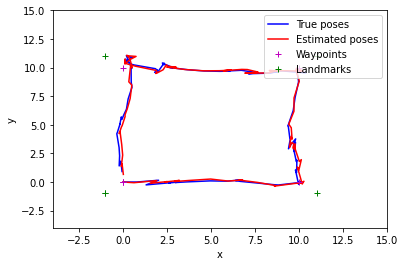

In [ ]:
def experiment1():
  """Write a function that creates a simulator and a set of waypoints. Then
  call follow_waypoints with the waypoints, and plot the true and estimated
  trajectories. """
  simulator = Simulator()
  #[Waypoint(0,0),Waypoint(5,0),Waypoint(10,0),Waypoint(10,5),Waypoint(10,10),Waypoint(5,10),Waypoint(0,10),Waypoint(0,5),Waypoint(0,0)]
  waypoints = [Waypoint(0,0),Waypoint(10,0),Waypoint(10,10),Waypoint(0,10),Waypoint(0,0)]
  re = follow_waypoints(simulator, waypoints, waypoint_threshold = 1, show_samples = False)
  plot_trajectories(re[0],re[1],waypoints,simulator.landmarks,-4,15,-4,15)
experiment1()

### Experiment 2: 

In this miniproject, we have modified the sensor model to have a maximum
range. If the robot is further than `max_range` from the landmark (i.e., out of
range), it won't get a range or bearing measurement from that landmark. 

Let's drive the robot through the same set of waypoints (0, 0)
to (10, 0), (10, 10), to (0, 10), and back to (0, 0) and plot the true and
estimated trajectory, but with the simulator `max_range` set to 2. (Note that we
have a `min_range` too. We don't want to localize off landmarks that are too
close because bearing noise at very close ranges can be really problematic.)

You should see significantly worse performance in terms of the robot's ability
to estimate its position or follow the desired trajectory. 

<div class="question question-multiplechoice">
<b>Submission Material 2:</b> In your submitted pdf, please include a single
figure which has the true and estimated trajectories. Name this figure as Figure 2.
</div>



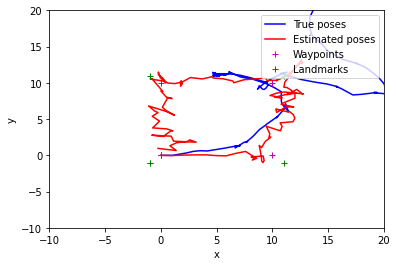

In [ ]:
def experiment2():
  """Write a function that creates a simulator and a set of waypoints. Set the
  simulator max_range field to be 2, and then call `follow_waypoints` with the
  waypoints, and plot the true and estimated trajectories. """
  
  simulator = Simulator()
  simulator.max_range = 2
  waypoints = [Waypoint(0,0),Waypoint(10,0),Waypoint(10,10),Waypoint(0,10),Waypoint(0,0)]
  re = follow_waypoints(simulator, waypoints, waypoint_threshold = 1, show_samples = False)
  plot_trajectories(re[0],re[1],waypoints,simulator.landmarks,-10,20,-10,20)
experiment2()

### Experiment 3: 

Now, in that previous question, there wasn't much the robot could do to
compensate for the impoverished range of its sensor. With a maximum range of
2, the landmarks are just too far apart to be able to get from one location to
another reliably.  

Let's make the problem a little more interesting -- imagine that our search
and rescue robot knows there are three people to be rescued at locations (10,
10), (0, 20) and (-10, 10). It starts off from the hospital at (0, 0) and must
return there with the three people.

We need landmarks that are more helpful in reaching these three rescue
locations. We have provided a helper function `set_landmarks_in_a_plus()`
inside the `Simulator` class that will change the landmarks to be a line of
landmarks 1m apart from (0,0) to (0, 20) and another line of landmarks 1m
apart from (-10, 10) to (10, 10). We will want you to use this helper function
to change the landmarks so they go from the hospital to each of the three
rescue locations

To get to the three rescue locations, the **shortest** length trajectory we
could imagine is one that takes a straight line path from the hospital to the
first person, continues to each of the remaining people and then returns to
the hospital. (Unlike in previous miniproejcts, in this scenario the robot can
carry more than one person.)

We can encode this trajectory by creating a list of waypoints from (0,0) to
(10, 10) to (0, 20), to (-10, 10), and back to (0, 0). Please do the following:
* call `set_landmarks_in_a_plus` to arrange the landmarks so they reach the
three rescue locations,
* set the `max_range` to be 2,
* call `follow_waypoints` with this list,
* and plot the true and estimated trajectory given by `follow_waypoints`.

<div class="question question-multiplechoice">
<b>Submission Material 3:</b> In your submitted pdf, please include a single
figure which has the true and estimated trajectories. Name this figure as
Figure 3.
</div>


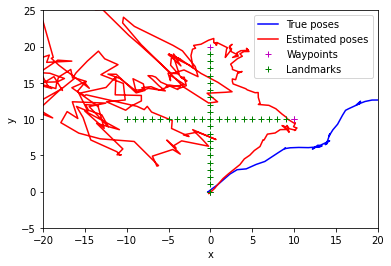

In [ ]:
def experiment3():
  """Write a function that creates a simulator and a set of waypoints.  Set
  landmarks to be a plus shape using set_landmarks_in_a_plus, set the
  simulator max_range field to be 2, and then call follow_waypoints with the
  list of 5 waypoints, and plot the true and estimated trajectories. """

  simulator = Simulator()
  simulator.max_range = 2
  simulator.set_landmarks_in_a_plus()
  waypoints = simulator.rescue_locations + [Waypoint(0,0)]
  re = follow_waypoints(simulator, waypoints, waypoint_threshold = 1, show_samples = False)
  plot_trajectories(re[0],re[1],waypoints,simulator.landmarks,-20,20,-5,25)
experiment3()

### Experiment 4: 

In the previous question, you should have seen that the robot wasn't able to
track its position or follow a reasonable trajectory. Even though there are a
lot more landmarks in the environment, its trajectory took it too far away to
use them.

Let's use the same landmark configuration created by `set_landmarks_in_a_plus()`
and keep the sensor `max_range` to be 2.

Our goal is still to rescue the three people at the known locations and get
back to the hospital, but let's create a plan that keeps the robot close to
the landmarks. Let's use waypoints (0, 10), (10, 10), (0, 10), (0, 20), (0,
10), (-10, 10), (0, 10), (0, 0), and plot the true and estimated trajectory
given by `follow_waypoints`.  This trajectory is the **longest** length
trajectory of the three we will consider.

What you should see is the robot is much better able to track and control its
position. Even though we're visiting the same four rescue locations as before
(three people and returning to the hospital), the path we choose has real impact on
the quality of our state estimate. The interaction between the plan and the
state estimate is a hallmark of POMDP problems.

<div class="question question-multiplechoice">
<b>Submission Material 4:</b> In your submitted pdf, please include a single
figure which has the true and estimated trajectories. Name this figure as
Figure 4.  Also, explain your answers to the following questions (on the Catsoop page).
</div>


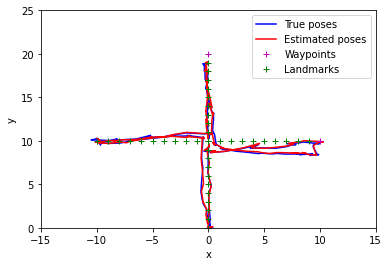

In [ ]:
def experiment4():
  """Write a function that creates a simulator and a set of waypoints. Set
  landmarks to be a plus shape using set_landmarks_in_a_plus, set the
  simulator max_range field to be 2, and then call `follow_waypoints` with the
  new waypoint list, and plot the true and estimated trajectories. """
  
  simulator = Simulator()
  simulator.max_range = 2
  simulator.set_landmarks_in_a_plus()
  waypoints = [Waypoint(0, 0),Waypoint(0, 10), Waypoint(10, 10), Waypoint(0, 10), Waypoint(0, 20), Waypoint(0, 10), Waypoint(-10, 10), Waypoint(0, 10), Waypoint(0, 0)]
  re = follow_waypoints(simulator, waypoints, waypoint_threshold = 1, show_samples = False)
  plot_trajectories(re[0],re[1],waypoints,simulator.landmarks,-15,15,0,25)
experiment4()
#MLS since you are choosing the most likely state and given its gaussian, you are very likely to just think you are following your trajectory and choose the shorter path
#MLO
#QMDP 
#Augmented MDP

### Experiment 5: 

We'd like to have some way of comparing the two plans. Let's implement the
same reward function as the discrete POMDP we described in the previous question. 

If you examine the Simulator class, you will see that we have provided some
helper fields:
* `rescue_locations`: a list of Waypoints that describe the same
`rescue_locations` as before
* `rescue_threshold`: how close the robot has to be to a person to pick them
up.
* `rescue_succeeded_reward`: the reward of successfully rescuing someone
* `rescue_failed_reward`: the reward of trying to rescue someone and failing
* `action_reward`: the cost of each motion action. 

Now let's modify `follow_waypoints` to compute the rewards. Look at the method
we've provided, `follow_waypoints_with_rewards` and modify it to calculate the
`total_actual_reward`, that is, the total reward incurred by the true (simulated)
robot during the trajectory, and the total estimated reward that the robot
*thinks* it incurred during the same trajectory. The method is marked with the
two places where you need to make modifications. We've already modified the
method to return the `total_actual_reward` and `total_expected_reward` variables for
you.

Notice that to make computing the costs easier for you, we've added a
`take_rescue_person_action` variable inside
`follow_waypoints_with_rewards`. When the robot thinks it has arrived at a
waypoint, we can check to see if the waypoint is the same as the location of
the rescue subgoal it is trying to reach. If it is, the
`take_rescue_person_action` variable will be true, and you can use that in
calculating costs.

You should also notice that the robot will decide if it has arrived at a
waypoint either when it is closer than `waypoint_threshold` to the waypoint,
or after taking 100 actions. 

Please write a method that runs `follow_waypoints_with_rewards` using the two
trajectories we have explored so far (shortest and longest from experiments 3
and 4), and returns the `total_actual_reward` and `total_expected_reward` for
both trajectories. Please also plot the true and estimated trajectories for
both.

Remember that the expected reward is what the robot *thinks* is going to be
the reward, and it's computed from the distribution of samples --- the reward
computed for each sample, divided by the number of samples, not simply by
using the mean of the samples. And it's not necessarily how well the robot is
actually going to do.

**Hint**: The performance is going to change from run to run. Very
occasionally, you may see counter-intuitive behaviour, where the performance
of the two trajectories flips. You should run your implementation multiple
times, and choose the most representative results. 

<div class="question question-multiplechoice">
<b>Submission Material 5:</b> In your submitted pdf, please include two 
figures which have the true and estimated trajectories for both sets of
waypoints. Name these figures as Figure 5a and Figure 5b.
</div>


In [ ]:
def follow_waypoints_with_rewards(simulator, waypoints, waypoint_threshold = 1.0,
                                  show_samples = False):
  """Drive the robot through a sequence of waypoints, where the control is
  based on the mean estimate of the samples."""

  num_samples = 100  # number of initial samples.
  mean = simulator.robot
  covariance = [[.1, 0, 0], [0, .1, 0], [0, 0, np.deg2rad(5)**2]]
  samples = np.random.multivariate_normal(mean, covariance, num_samples)

  true_poses = []
  true_poses.append(simulator.robot)
  estimated_poses = []
  estimated_poses.append(mean)

  max_move = 1
  max_turn = np.deg2rad(30)

  total_actual_reward = 0
  total_expected_reward = 0 
  
  if show_samples:
    plot_samples(samples, xmin=-11, xmax=12, ymin=-1, ymax=22)

  next_rescue_subgoal_index = 0

  for waypoint in waypoints:
    attempts = 0
    while True:
      waypoint_achieved = False
      take_rescue_person_action = False 
      distance = np.hypot(waypoint.x - mean.x, waypoint.y - mean.y)
      angle = math.atan2(waypoint.y - mean.y, waypoint.x - mean.x) - mean.theta
      if (angle > np.pi):
        angle -= 2*np.pi
        if (angle < -np.pi):
          angle += 2*np.pi 

      if distance < waypoint_threshold or attempts > 100:
        waypoint_achieved = True
        if np.hypot(waypoint.x - simulator.rescue_locations[next_rescue_subgoal_index].x,
                    waypoint.y - simulator.rescue_locations[next_rescue_subgoal_index].y) < .1:
          take_rescue_person_action = True
          next_rescue_subgoal_index += 1
        else:
          take_rescue_person_action = False
      else:
        t_command = 0
        theta_command = 0
        if (np.abs(angle) > np.deg2rad(10)):
          theta_command = min(np.abs(angle), max_turn)*np.sign(angle)
        elif (distance > .2):
          t_command = min(distance, max_move)

        
      ###
      ### Modify the method here to calculate the true reward and the expected
      ### reward
      ###

      if take_rescue_person_action:
        if np.hypot(simulator.robot.x - simulator.rescue_locations[next_rescue_subgoal_index-1].x,simulator.robot.y - simulator.rescue_locations[next_rescue_subgoal_index-1].y) < simulator.rescue_threshold:
          total_actual_reward+= simulator.rescue_succeeded_reward
        else:
          total_actual_reward+= simulator.rescue_failed_reward
        expected_reward = 0
        for s in samples:
          dis =np.hypot(s[0] - simulator.rescue_locations[next_rescue_subgoal_index-1].x,s[1] - simulator.rescue_locations[next_rescue_subgoal_index-1].y)
          if dis <  simulator.rescue_threshold:
            expected_reward+=simulator.rescue_succeeded_reward
          else:
            expected_reward+= simulator.rescue_failed_reward
        expected_reward = expected_reward/samples.shape[0]
        total_expected_reward+=expected_reward
      else:
        total_actual_reward+= simulator.action_reward
        total_expected_reward+= simulator.action_reward

      ###
      ### End of needed modifications
      ### 

      if waypoint_achieved:
        break
      else: 
        command = Command(t_command, theta_command)
        attempts += 1

      # Step 1: Simulate the robot motion and append it to true_poses.
      simulator.simulate_motion(command)

      true_poses.append(simulator.robot)
      measurement = simulator.simulate_sensing()

      # Step 2: Compute the estimated motion based on the commanded motion and
      # received measurement using update_samples and then append the mean of
      # the samples to estimated_poses.
      samples = update_samples(samples, command, measurement,
                               simulator.landmarks,
                               simulator.motion_noise_covariance,
                               simulator.sensor_noise_covariance,
                               simulator.robot)
      mean_array = np.mean(samples, axis=0)
      mean = Pose(mean_array[0], mean_array[1], mean_array[2])
      estimated_poses.append(mean_array)

    if show_samples:
      plot_samples(samples, xmin=-11, xmax=12, ymin=-1, ymax=22)

  return np.array(true_poses), np.array(estimated_poses), \
         total_actual_reward, total_expected_reward

def follow_waypoints_with_rewards_test():
  np.random.seed(0)
  sim = Simulator()
  sim.max_range = 2
  waypoints = [Waypoint(10, 10), Waypoint(0, 20), 
               Waypoint(-10, 10), Waypoint(0, 0)]
  true_poses, estimated_poses, total_actual_reward, total_expected_reward = \
    follow_waypoints_with_rewards(sim, waypoints)
  print(total_expected_reward)
  assert abs(-40122 - total_actual_reward) < 10
  assert abs(-28608 - total_expected_reward) < 10

# When you are ready to test your code, uncomment this line
follow_waypoints_with_rewards_test()

-28608.0


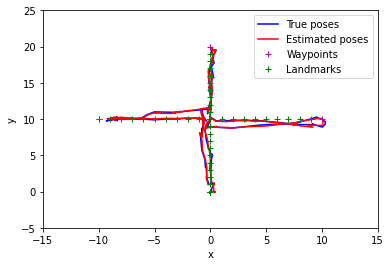

243 -4201.0


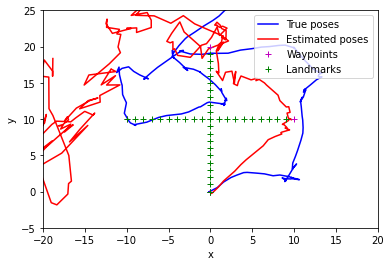

-40258 -39450.0


In [ ]:
def experiment5():
  """Write a function that creates a simulator and a set of waypoints. Set
  landmarks to be a plus shape using set_landmarks_in_a_plus, set the
  simulator max_range field to be 2, and then call follow_waypoints with 
  both waypoint sequences (the longest and shortest sequences from experiment
  3 and 4) and return the total_actual_reward and total_expected_reward for
  both. """ 
  
  simulator = Simulator()
  simulator.max_range = 2
  simulator.set_landmarks_in_a_plus()
  waypoints = [Waypoint(0, 0),Waypoint(0, 10), Waypoint(10, 10), Waypoint(0, 10), Waypoint(0, 20), Waypoint(0, 10), Waypoint(-10, 10), Waypoint(0, 10), Waypoint(0, 0)]
  re = follow_waypoints_with_rewards(simulator, waypoints, waypoint_threshold = 1, show_samples = False)
  plot_trajectories(re[0],re[1],waypoints,simulator.landmarks,-15,15,-5,25)
  print(re[2],re[3])
  simulator2 = Simulator()
  simulator2.max_range = 2
  simulator2.set_landmarks_in_a_plus()
  waypoints2 = [Waypoint(0,0),Waypoint(10, 10),Waypoint(0, 20),Waypoint(-10, 10),Waypoint(0,0)]
  re2 = follow_waypoints_with_rewards(simulator2, waypoints2, waypoint_threshold = 1, show_samples = False)
  plot_trajectories(re2[0],re2[1],waypoints2,simulator2.landmarks,-20,20,-5,25)
  print(re2[2],re2[3])
experiment5()
#233 -70.0 -30035 -34378.0

### Experiment 6: 

We don't have to make the policy be that we switch waypoints with the same
tolerance as the `rescue_threshold` parameter. There is a separate parameter
`waypoint_threshold` used by `follow_waypoints_with_rewards` with default
value of 1 that determines
how close our policy has to get to the waypoint, before moving onto the next
waypoint. (Remember that we don't get reward by arriving at a waypoint -- we
get reward by taking a rescue action at a rescue location.)

Please call `follow_waypoints_with_rewards` with the `waypoint_threshold` to
be 0.2. Re-run the same two waypoint patterns from the previous experiments,
return the `total_actual_reward` and `total_expected_reward` for both
trajectories, and plot the true and estimated trajectories for both.

<div class="question question-multiplechoice">
<b>Submission Material 6:</b> In your submitted pdf, please include two 
figures which have the true and estimated trajectories for both sets of
waypoints. Name these figures as Figure 6a and Figure 6b.  Also, explain your
answers to the following questions (on the Catsoop page). 
</div>


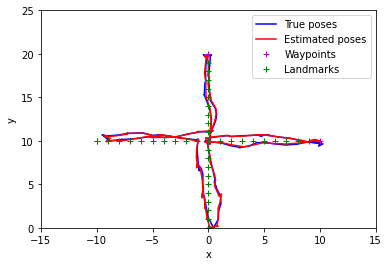

-19962 -2994.0


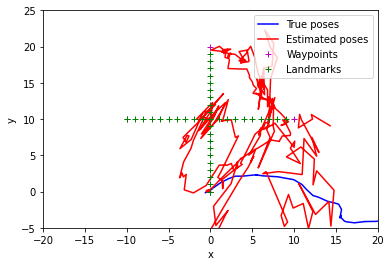

-40259 -40259.0


In [ ]:
def experiment6():
  """Write a function that creates a simulator and a set of waypoints. Set
  landmarks to be a plus shape using set_landmarks_in_a_plus, set the
  simulator max_range field to be 2, set the waypoint_threshold to be 0.2 and
  then call follow_waypoints with the waypoints for both waypoint sequences."""
  
  simulator = Simulator()
  simulator.max_range = 2
  simulator.set_landmarks_in_a_plus()
  simulator.rescue_threshold = 1
  waypoints = [Waypoint(0, 0),Waypoint(0, 10), Waypoint(10, 10), Waypoint(0, 10), Waypoint(0, 20), Waypoint(0, 10), Waypoint(-10, 10), Waypoint(0, 10), Waypoint(0, 0)]
  re = follow_waypoints_with_rewards(simulator, waypoints, waypoint_threshold = 1, show_samples = False)
  plot_trajectories(re[0],re[1],waypoints,simulator.landmarks,-15,15,0,25)
  print(re[2],re[3])
  simulator2 = Simulator()
  simulator2.max_range = 2
  simulator2.set_landmarks_in_a_plus()
  simulator2.rescue_threshold = 1
  waypoints2 = [Waypoint(0,0),Waypoint(10, 10),Waypoint(0, 20),Waypoint(-10, 10),Waypoint(0,0)]
  re2 = follow_waypoints_with_rewards(simulator2, waypoints2, waypoint_threshold = 1, show_samples = False)
  plot_trajectories(re2[0],re2[1],waypoints2,simulator2.landmarks,-20,20,-5,25)
  print(re2[2],re2[3])
experiment6() 
#189,189.0 -30121 -20021.0

### Experiment 7: 

Let's try one more trajectory, that doesn't follow the landmarks quite as
closely. Let's try cutting some corners, and follow this set of waypoints:  
[(0, 5), (5, 10), (10, 10), (5,10), (0, 15), (0,20), (0, 15), (-5, 10), (-10,
10), (-5, 10), (0, 5),(0, 0)]. This trajectory is the **medium** length trajectory
of our three. 

Please change the `waypoint_threshold` to be 0.2. Run
the new waypoint pattern and return the `total_actual_reward` and
`total_expected_reward` for this trajectory, and plot the true and estimated
trajectory for this pattern. 

<div class="question question-multiplechoice">
<b>Submission Material 7:</b> In your submitted pdf, please include two 
figures which have the true and estimated trajectories for these
waypoints. Name these figures as Figure 7.  Also, explain your answers to the following questions (on the Catsoop page).
</div>


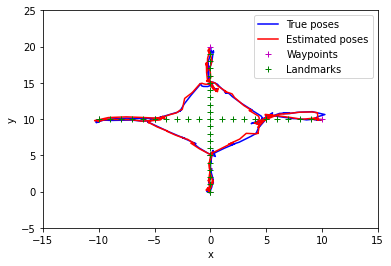

193 193.0


In [ ]:
def experiment7():
  """Write a function that creates a simulator and a set of waypoints. Set
  landmarks to be a plus shape using set_landmarks_in_a_plus, set the
  simulator max_range field to be 2, set the waypoint_threshold to be 0.2 and
  then call follow_waypoints with the new set of waypoints."""
  
  simulator = Simulator()
  simulator.max_range = 2
  simulator.set_landmarks_in_a_plus()
  waypoints = [Waypoint(0, 5), Waypoint(5, 10), Waypoint(10, 10), Waypoint(5,10), Waypoint(0, 15), Waypoint(0,20), Waypoint(0, 15), Waypoint(-5, 10), Waypoint(-10, 10), Waypoint(-5, 10), Waypoint(0, 5),Waypoint(0, 0)]
  re = follow_waypoints_with_rewards(simulator, waypoints, waypoint_threshold = 0.2, show_samples = False)
  plot_trajectories(re[0],re[1],waypoints,simulator.landmarks,-15,15,-5,25)
  print(re[2],re[3])
experiment7()
#193,193.0

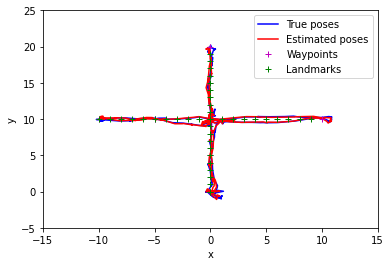

-153 -153.0


In [ ]:
def experiment8():
  
  simulator = Simulator()
  simulator.max_range = 2
  simulator.set_landmarks_in_a_plus()
  waypoints = [Waypoint(0, 10), Waypoint(0,20), Waypoint(0, 15), Waypoint(0, 10), Waypoint(-5,10), Waypoint(-10, 10), Waypoint(-5,10), Waypoint(0,10), Waypoint(10, 10), Waypoint(0, 10), Waypoint(0, 5),Waypoint(0, 0)]
  re = follow_waypoints_with_rewards(simulator, waypoints, waypoint_threshold = 0.2, show_samples = False)
  plot_trajectories(re[0],re[1],waypoints,simulator.landmarks,-15,15,-5,25)
  print(re[2],re[3])
experiment8()
#193,193.0